### **1. DATA COLLECTION**

In [1]:
#pip install bs4
#pip install selenium
#pip install forex-python

In [19]:
#import the required packages
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import os
import time
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import heapq
import nltk
from nltk.stem import *
from nltk.corpus import stopwords 
import re
from collections import Counter
from functools import reduce



#### 1.1. Get the list of master's degree courses

In [20]:
flag = False # run only once

if flag:
    # URL of the website
    url = 'https://www.findamasters.com/masters-degrees/msc-degrees/?PG='  
    prefix = '/masters-degrees/course/'
    exclude = ['\nMore details \n', '\nRead more \n', '\xa0Video(s)', '\xa0Student Profile(s)'] 

    # Create a list to store the URLs of the masters
    master_urls = []

    # Loop through the first 400 pages
    for page_number in range(1, 401):
        print(url + str(page_number))
        response = requests.get(url + str(page_number))

        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
        
            # Use BeautifulSoup to extract the URLs and append them to the master_urls list
            for link in soup.find_all('a', {'class':'courseLink'}):
                if link['href'][:len(prefix)] == prefix and not link.text in exclude:
                    master_urls.append((link['href'], link.text))


    # Save the collected URLs in a text file
    with open("master_urls.txt", "a") as file:
        for url in master_urls:
            file.write(url[0] + "\n")

#### 1.2. Crawl master's degree pages

In [21]:
flag = False

if flag:
    # Open the file and read its content
    with open("master_urls.txt", "r") as file:
        master_urls = [line.strip() for line in file.readlines()]

    # Create a directory to store HTML pages
    output_root_directory = "html_pages"
    os.makedirs(output_root_directory, exist_ok=True)  # create the directory if it doen't exist

    # Read 15 URLs at a time and create HTML pages
    subset_size = 15
    for i in range(0, len(master_urls), subset_size):
        subset = master_urls[i:i + subset_size] # extract 15 more urls

        # Create a subfolder for each page
        output_directory = os.path.join(output_root_directory, f"page_{i // subset_size + 1}")
        os.makedirs(output_directory, exist_ok=True)

        # Create an HTML page for each URL in the subset
        for url in subset:
            prefix = 'https://www.findamasters.com/'
            response = requests.get(prefix + url)  # sends a GET request 

            if response.status_code == 200:
                soup = BeautifulSoup(response.text, "html.parser")
                page_content = soup.prettify()  # extract the content of the page          
                master_name = url.split("/")[-2]  # extract the name of the master from the URL 

                # Check if the file already exists, and append a number if necessary
                page_filename = f"{output_directory}/{master_name}.html"
                counter = 1
                while os.path.exists(page_filename):
                    page_filename = f"{output_directory}/{master_name}({counter}).html"
                    counter += 1

                # Save the content in a HTML file
                with open(page_filename, "w", encoding="utf-8") as file:
                    file.write(page_content)
            time.sleep(1.5)

        print(f"page {i // subset_size + 1} completed")
   

#### 1.3 Parse downloaded pages

In [22]:
##MY IDEA --> I have to create a function that retrieve the required information from a html page. in order to do so I exploit the structure of the file. 
#I use "try: except:" to avoid errors in the case that some information is missing

def extract_msc_page(msc_page_url):


    contents ={}
    # Parse HTML content
    page_soup = BeautifulSoup(msc_page_url, 'html.parser')

    #url
    try:
        canonical_link = page_soup.find('link', {'rel': 'canonical'})
        contents['url'] = canonical_link.get('href')
    except AttributeError:
        contents['url'] = ""


    # Course name
    try:
        page_links = page_soup.find('h1', {'class': 'text-white course-header__course-title'})
        name = page_links.get_text()
        contents["courseName"] = name.strip()
    except AttributeError:
        contents['courseName'] = ""

    # University name
    try:
        page_links = page_soup.find_all('a', {'class': 'course-header__institution'})
        contents['universityName'] = page_links[0].contents[0].strip()
    except (AttributeError, IndexError):
        contents['universityName'] = ""

    # Faculty name
    try:
        page_links = page_soup.find_all('a', {'class': 'course-header__department'})
        contents['facultyName'] = page_links[0].contents[0].strip()
    except (AttributeError, IndexError):
        contents['facultyName'] = ""

    # Full time
    try:
        page_links = page_soup.find('a', {'class': 'inheritFont concealLink text-decoration-none text-gray-600'})
        time = page_links.get_text().strip()
        contents['isItFullTime'] = time
    except AttributeError:
        contents['isItFullTime'] = ""

    # Description
    try:
        page_links = page_soup.find('div', {'id': 'Snippet'})
        description = page_links.get_text().strip()
        contents["description"] = description
    except AttributeError:
        contents['description'] = ""

    # Starting date
    try:
        page_links = page_soup.find('span', {'class': 'key-info__content key-info__start-date py-2 pr-md-3 text-nowrap d-block d-md-inline-block'})
        starting = page_links.get_text().strip()
        contents["startDate"] = starting
    except AttributeError:
        contents['startDate'] = ""

    # Fees
    try:
        page_links = page_soup.find('div', {'class': 'course-sections course-sections__fees tight col-xs-24'})
        fees = page_links.get_text().strip()
        contents["fees"] = fees
    except AttributeError:
        contents['fees'] = ""

    # Modality
    try:
        page_links = page_soup.find('a', {'title': 'View all MSc courses'})
        modality = page_links.get_text().strip()
        contents["modality"] = modality
    except AttributeError:
        contents['modality'] = ""

    # Duration
    try:
        page_links = page_soup.find('span', {'class': 'key-info__content key-info__duration py-2 pr-md-3 d-block d-md-inline-block'})
        duration = page_links.get_text().strip()
        contents["duration"] = duration
    except AttributeError:
        contents['duration'] = ""

    # City
    try:
        page_links = page_soup.find('a', {'class': 'card-badge text-wrap text-left badge badge-gray-200 p-2 m-1 font-weight-light course-data course-data__city'})
        city = page_links.get_text().strip()
        contents["city"] = city
    except AttributeError:
        contents['city'] = ""

    # Country
    try:
        page_links = page_soup.find('a', {'class': 'card-badge text-wrap text-left badge badge-gray-200 p-2 m-1 font-weight-light course-data course-data__country'})
        country = page_links.get_text().strip()
        contents["country"] = country
    except AttributeError:
        contents['country'] = ""

    # Administration
    try:
        page_links = page_soup.find('a', {'class': 'card-badge text-wrap text-left badge badge-gray-200 p-2 m-1 font-weight-light course-data course-data__on-campus'})
        administration = page_links.get_text().strip()
        contents["administration"] = administration
    except AttributeError:
        contents["administration"] = ""

    
    return contents


In [23]:
## MY IDEA --> I apply the function above for all the files. I am applying it for all files in a folder for all folders contained into a folder

flag = False

if flag:
    folder_path = 'html_pages/'

    result_df = pd.DataFrame()
    # Walk through the directory and its subdirectories
    for foldername, subfolders, filenames in os.walk(folder_path):
        # Iterate through all the files in the current subdirectory
        for filename in filenames:
            # Construct the file path
            path = os.path.join(foldername, filename)
        
            # Check if the file exists before attempting to open it
            if os.path.exists(path):
                # Print the file path
                print(path)
            
                # Open the file in read mode with UTF-8 encoding
                with open(path, 'r', encoding='utf-8') as file:
                    # Read the HTML content of the file
                    html_content = file.read()
                
                    # Call the function to extract information from the HTML content
                    result_dict = extract_msc_page(html_content)
                    result_df = result_df.append(result_dict, ignore_index=True)


            else:
                # Print a message if the file is not found
                print(f"File not found: {path}")


    #clean an imperfection in the fees section
    result_df['fees'] = result_df['fees'].str.replace('Fees', '') 

    #save it into a file to store it. so that I do not have to run it again
    result_df.to_json('html_pages.json', orient='records', lines=True)


In [25]:
# Create ths tsv files

flag = False

if flag:
    data = pd.read_json("html_pages.json", lines=True)

    output_directory_masters = "tsv_files"
    os.makedirs(output_directory_masters, exist_ok=True)

    # Extract relevant columns
    selected_columns = ['courseName', 'universityName', 'facultyName', 'isItFullTime', 'description', 'startDate', 'fees', 'modality', 'duration', 'city', 'country', 'administration', 'url']

    # Concatenate all rows into a single DataFrame
    selected_data_all_courses = data[selected_columns].replace('\n', '', regex=True).replace('\t', '', regex=True)

    # Convert the concatenated data to a string with '\n' as the separator
    all_courses_string = selected_data_all_courses.to_csv(sep='\t', index=False, header=False, lineterminator='\n')

    # Split the string into individual lines
    lines = all_courses_string.split('\n')
       
    for index, line in enumerate(lines):
        # Skip empty lines
        if not line:
            continue

        # Create a unique TSV file for each line
        file_name = f"course_{index}.tsv"
        file_path = os.path.join(output_directory_masters, file_name)

        # Write the line to the TSV file
        with open(file_path, 'w') as file:
            file.write(line + '\n')


### **2. Search Engine**

##### 2.0.0) Preprocessing the text

In [17]:
dataset = pd.read_json("html_pages.json", lines=True)  # read the dataset from the created json file
dataset = dataset[dataset.description != '']  # filter rows where the 'description' is empty

# STEMMING
stemmer = PorterStemmer()  # create an instance of Porter Stemmer
dataset['preprocessed_description'] = dataset.description.apply(lambda row: [stemmer.stem(word) for word in row.split(' ')])  # reduce words of description column to their root form and create a new column to store the result
#snowstem = snowball.SnowballStemmer('english')
#lst_snow = [snowstem.stem(word) for word in dataset.loc[0,'description'].split(' ')]

# STOPWORDS
nltk.download('stopwords') 
list_stopwords = stopwords.words('english')  # retrieves the English stopwords from the nltk stopwords dataset
dataset['preprocessed_description'] = dataset.description.apply(lambda row: [stemmer.stem(word) for word in row.split(' ') if not word in list_stopwords])  # now 'descr_clean' column contains lists of cleaned and stemmed words 

# PUNCTUATION
nltk.download('punkt')
dataset['preprocessed_description'] = dataset.description.apply(lambda row: [stemmer.stem(word) for word in nltk.word_tokenize(row) if not word in list_stopwords and word.isalnum()]) # now 'descr_clean' column contains lists of cleaned and stemmed words without punctuation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#### 2.0.1) Preprocessing the fees column

In [43]:
from forex_python.converter import CurrencyRates

pattern1 = r'([$£¥€]|USD|GBP|EUR|euro|euros|JPY|HK$|HK|HKD$|HKD|ISK|SEK)\s*([\d,]+(?:\.\d+)?)'  # regex to match pattern "symbol number"
pattern2 = r'([\d,]+(?:\.\d+)?)\s*([$£¥€]|USD|GBP|EUR|euro|euros|JPY|HK$|HK|HKD$|HKD|ISK|SEK)'  # regex to match pattern "number symbol"

currency_rates = CurrencyRates()  # create a CurrencyRates instance


def extract_and_convert(row, common_currency="USD"):  # method to extract fee values from the 'fees' column and convert them all to the same currency (Dollars)

    matches1 = re.finditer(pattern1, row)
    matches2 = re.finditer(pattern2, row)

    # initialize 'max_value' and the currency of the maximum value to update within the for loops below
    max_value = 0
    max_currency = None
    max_match = None

    # iterate over the matches obtained from the first regex
    for match in matches1:
        currency_symbol = match.group(1)
        numeric_part = match.group(2)
        
        
        # Try to convert numeric part to float
        try:
            numeric_value = float(numeric_part.replace(',', '').replace('.', '')) # remove the commas and dots used as thousands separators and cast to float
        except ValueError:
            continue
        
        # update max value if necessary
        if numeric_value > max_value:  
            max_value = numeric_value
            max_currency = currency_symbol
            max_match = match
    
    # iterate over the matches obtained from the second regex and do what was done in the above loop
    for match in matches2:
        currency_symbol = match.group(2)
        numeric_part = match.group(1)
        
        try:
            numeric_value = float(numeric_part.replace(',', '').replace('.', '')) 
        except ValueError:
            continue
        
        if numeric_value > max_value: 
            max_value = numeric_value
            max_currency = currency_symbol
            max_match = match
    

    if max_match:
        # Convert the price to the common currency
        converted_price = convert_currency(max_currency, max_value, common_currency)  # call the convert_currency method defined below
        return converted_price
    else:
        return None



# Define a function to convert currency
def convert_currency(currency_symbol, amount, target_currency):
    try:
        # Map currency symbols to ISO codes
        currency_code = symbol_to_code(currency_symbol)  
        
        if currency_code is not None:
            # Use the forex-python library to get the exchange rate and perform the conversion
            exchange_rate = currency_rates.get_rate(currency_code, target_currency)
            converted_amount = round(amount * exchange_rate, 2)
            print(f"currency exchange: {amount:.2f}{currency_code} --> {converted_amount:.2f}{target_currency}")
            return converted_amount
        else:
            print(f"Unsupported currency symbol: {currency_symbol}")
            return None
    except Exception as e:
        print(f"Error converting currency: {e}")
        return None



# Define a function to map currency symbols to ISO codes using a dictionary
def symbol_to_code(symbol):
    symbol_map = {
        '$': 'USD',
        '£': 'GBP',
        '¥': 'JPY',
        '€': 'EUR',
        'USD': 'USD',
        'GBP': 'GBP',
        'EUR': 'EUR',
        'euro': 'EUR',
        'euros': 'EUR',
        'JPY': 'JPY',
        'HKD$': 'HKD',
        'HKD': 'HKD',
        'HK$': 'HKD',
        'HK': 'HKD',
        'ISK': 'ISK',
        'SEK': 'SEK'
    }
    return symbol_map.get(symbol, None)


# Apply the function to the 'fees' column and create a new 'fees(USD)' column
dataset['fees(USD)'] = dataset['fees'].apply(lambda x: extract_and_convert(x, common_currency='USD'))


currency exchange: 34750.00GBP --> 42542.88USD
currency exchange: 31000.00GBP --> 37951.92USD
currency exchange: 18000.00EUR --> 19206.00USD
currency exchange: 18000.00EUR --> 19206.00USD
currency exchange: 15000.00EUR --> 16005.00USD
currency exchange: 15000.00EUR --> 16005.00USD
currency exchange: 28750.00GBP --> 35197.35USD
currency exchange: 722.00GBP --> 883.91USD
currency exchange: 31000.00GBP --> 37951.92USD
currency exchange: 28000.00GBP --> 34279.16USD
currency exchange: 10500.00GBP --> 12854.68USD
currency exchange: 22600.00EUR --> 24114.20USD
currency exchange: 22600.00EUR --> 24114.20USD
currency exchange: 4000.00EUR --> 4268.00USD
currency exchange: 18000.00GBP --> 22036.60USD
currency exchange: 280600.00SEK --> 25788.13USD
currency exchange: 2500.00EUR --> 2667.50USD
currency exchange: 26350.00GBP --> 32259.14USD
currency exchange: 26350.00GBP --> 32259.14USD
currency exchange: 26350.00GBP --> 32259.14USD
currency exchange: 26350.00GBP --> 32259.14USD
currency exchange: 4

,url,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,preprocessed_description,fees(USD)
0,https://www.findamasters.com/masters-degrees/c...,3D Design for Virtual Environments - MSc,Glasgow Caledonian University,School of Engineering and Built Environment,Full time,3D visualisation and animation play a role in ...,September,\n \n\n\n\n Please see th...,MSc,1 year full-time,Glasgow,United Kingdom,On Campus,"[3d, visualis, anim, play, role, mani, area, p...",NaN
1,https://www.findamasters.com/masters-degrees/c...,"Accounting, Accountability & Financial Managem...",King’s College London,King’s Business School,Full time,"Our Accounting, Accountability & Financial Man...",September,\n \n\n\n\n Please see th...,MSc,1 year FT,London,United Kingdom,On Campus,"[our, account, account, financi, manag, msc, c...",NaN
2,https://www.findamasters.com/masters-degrees/c...,Accounting and Finance - MSc,University of Leeds,Leeds University Business School,Full time,Businesses and governments rely on sound finan...,September,"\n \n\n\n UK: £18,000 (Tot...",MSc,1 year full time,Leeds,United Kingdom,On Campus,"[busi, govern, reli, sound, financi, knowledg,...",42542.88
3,https://www.findamasters.com/masters-degrees/c...,"Accounting, Financial Management and Digital B...",University of Reading,Henley Business School,Full time,Embark on a professional accounting career wit...,September,\n \n\n\n\n Please see th...,MSc,1 year full time,Reading,United Kingdom,On Campus,"[embark, profession, account, career, academ, ...",NaN
4,https://www.findamasters.com/masters-degrees/c...,Addictions MSc,King’s College London,"Institute of Psychiatry, Psychology and Neuros...",Full time,Join us for an online session for prospective ...,September,\n \n\n\n\n Please see th...,MSc,One year FT,London,United Kingdom,On Campus,"[join, us, onlin, session, prospect, student, ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,https://www.findamasters.com/masters-degrees/c...,Bioinformatics MSc,University of Liverpool,Department of Life Sciences,Full time,Life sciences and technology are an integral p...,September,\n \n\n\n UK fees (applies...,MSc,"1 year full time, 2 years part time",Liverpool,United Kingdom,On Campus,"[life, scienc, technolog, integr, part, global...",30300.33
5996,https://www.findamasters.com/masters-degrees/c...,BioInnovation - MSc,Aberystwyth University,"Biological, Environmental & Rural Sciences (IB...",Part time,MSc BioInnovation at Aberystwyth University pr...,"September, January",\n \n\n\n\n Please see th...,MSc,5 years part time,Aberystwyth,United Kingdom,On Campus,"[msc, bioinnov, aberystwyth, univers, provid, ...",NaN
5997,https://www.findamasters.com/masters-degrees/c...,Biological Photography and Imaging MSc,University of Nottingham,School of Life Sciences,Full time,Have you ever wanted to work on nature documen...,September,\n \n\n\n\n Please see th...,MSc,Full time - 12 months,Nottingham,United Kingdom,On Campus,"[have, ever, want, work, natur, documentari, a...",NaN
5998,https://www.findamasters.com/masters-degrees/c...,"Biological Sciences (M.A., M.S.)",St. Cloud State University,Postgraduate Programs,Full time,You will gain in-depth knowledge and skills in...,See Course,"\n \n\n\n $7,385* per year...",MSc,2 years,St Cloud,USA,On Campus,"[you, gain, knowledg, skill, chosen, disciplin...",44760.00


### 2.1. Conjunctive query

#### 2.1.1) Create your index!

In [48]:
#step 1:
#Create a file named vocabulary, in the format you prefer, that maps each word to an integer (term_id).

vocabulary = set()
dataset.preprocessed_description.apply(lambda row: [vocabulary.add(word) for word in row])

0       [None, None, None, None, None, None, None, Non...
1       [None, None, None, None, None, None, None, Non...
2       [None, None, None, None, None, None, None, Non...
3       [None, None, None, None, None, None, None, Non...
4       [None, None, None, None, None, None, None, Non...
                              ...                        
5995    [None, None, None, None, None, None, None, Non...
5996    [None, None, None, None, None, None, None, Non...
5997    [None, None, None, None, None, None, None, Non...
5998    [None, None, None, None, None, None, None, Non...
5999    [None, None, None, None, None, None, None, Non...
Name: preprocessed_description, Length: 5979, dtype: object

In [49]:
vocabulary_alt = Counter(reduce(lambda x, y: x + y, dataset.preprocessed_description.values)).keys()

index = {}
unique_id = 1
for word in list(vocabulary_alt):
  index[unique_id] = word
  unique_id += 1

# Create a DataFrame from the vocabulary
vocabulary_df_alt = pd.DataFrame(list(index.items()), columns=['term_id', 'word'])

# Save the vocabulary DataFrame to a CSV file
vocabulary_df_alt.to_csv('vocabulary_alt.csv', index=False)


terms = pd.DataFrame(data=list(vocabulary_alt), columns=['term'])


#### 2.1.2) Execute the query


In [75]:

def execute_query():
    personalized_query = str(input())

    #personalized_query = "3d group"

    # Split the personalized query into individual words
    query_words = personalized_query.split()

    # Your modified code to get the indices of documents containing all words in the personalized query
    selected_indices = list(dataset.loc[dataset.preprocessed_description.apply(lambda row: all(word in row for word in query_words))].index)

    # Extract information for each selected document
    selected_documents = dataset.loc[selected_indices, ['courseName', 'universityName', 'description', 'url']]

    # Return the information for each selected document
    return selected_documents

selected_documents = execute_query()
selected_documents


,courseName,universityName,description,url
1,"Accounting, Accountability & Financial Managem...",King’s College London,"Our Accounting, Accountability & Financial Man...",https://www.findamasters.com/masters-degrees/c...
2,Accounting and Finance - MSc,University of Leeds,Businesses and governments rely on sound finan...,https://www.findamasters.com/masters-degrees/c...
9,"Agricultural, Environmental and Resource Econo...",University of Helsinki,Goal of the pro­gramme\n \n\n ...,https://www.findamasters.com/masters-degrees/c...
13,Applied Computer Science and Artificial Intell...,University of Bradford,Computer science is the foundation of many exc...,https://www.findamasters.com/masters-degrees/c...
23,Global Mental Health MSc,King’s College London,Global Mental Health MSc is jointly run by Kin...,https://www.findamasters.com/masters-degrees/c...
...,...,...,...,...
5992,Bioinformatics MSc,Teesside University,As biological sciences have become more data d...,https://www.findamasters.com/masters-degrees/c...
5995,Bioinformatics MSc,University of Liverpool,Life sciences and technology are an integral p...,https://www.findamasters.com/masters-degrees/c...
5996,BioInnovation - MSc,Aberystwyth University,MSc BioInnovation at Aberystwyth University pr...,https://www.findamasters.com/masters-degrees/c...
5998,"Biological Sciences (M.A., M.S.)",St. Cloud State University,You will gain in-depth knowledge and skills in...,https://www.findamasters.com/masters-degrees/c...


### 2.2) Conjunctive query & Ranking score

#### 2.2.1) Inverted index

In [56]:
tfidf = TfidfVectorizer(input = "content", lowercase= False, tokenizer = lambda text: text, max_df=0.5, min_df = 2)

results = tfidf.fit_transform(dataset.preprocessed_description)
result_dense = results.todense()
pd.DataFrame(result_dense.tolist(), index=dataset.index, columns=tfidf.get_feature_names_out())


tfidf_data = pd.DataFrame(result_dense.tolist(), index=dataset.index, columns=tfidf.get_feature_names_out())
cosine_sim = cosine_similarity(tfidf_data)

c:\Users\Mario\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [71]:
def search_engine(query, k=5):
    # Tokenize and preprocess the query
    query_tfidf = tfidf.transform([query])

    # Compute cosine similarity between the query and all documents
    query_similarity = cosine_similarity(query_tfidf, tfidf_data)

    # Create a heap to maintain the top-k documents
    heap = []

    # Iterate through the documents and update the heap
    for i, sim_score in enumerate(query_similarity[0]):
        heapq.heappush(heap, (sim_score, i))

    # Retrieve the top-k documents from the heap
    top_k_documents = []
    while heap and len(top_k_documents) < k:
        sim_score, index = heapq.heappop(heap)
        if sim_score > 0:
            document_info = {
                'courseName': dataset.loc[index, 'courseName'],
                'universityName': dataset.loc[index, 'universityName'],
                'description': dataset.loc[index, 'description'],
                'url': dataset.loc[index, 'url'],
                'Similarity Score': sim_score
            }
            top_k_documents.append(document_info)

    result_df = pd.DataFrame(top_k_documents)

    return result_df


##### 2.2.2) Execute the query

In [72]:
#USING IT BY CHANGING THE CODE
query = "advanced knowledge"
top_k_results = search_engine(query, k=5)


#USING IT BY DOING AN INPUT.
personalized_query = str(input())
top_k_results = search_engine(personalized_query, k=5)

top_k_results

,courseName,universityName,description,url,Similarity Score
0,Applied Sciences and Engineering: Computer Sci...,Vrije Universiteit Brussel,The programme prepares you for an active role ...,https://www.findamasters.com/masters-degrees/c...,0.006948
1,European Master in Archaeological Materials Sc...,University of Evora,WHAT?\n \n\n\n ARCHM...,https://www.findamasters.com/masters-degrees/c...,0.007127
2,Human Movement Sciences MSc,Vrije Universiteit Amsterdam,How to break a speed record on a bike at an al...,https://www.findamasters.com/masters-degrees/c...,0.010097
3,Classics (MSc),University of Edinburgh,Programme description\n \n\n\n ...,https://www.findamasters.com/masters-degrees/c...,0.015836
4,Managing Risk and System Change (Online) - MSc...,Trinity College Dublin,This online course is relevant to safety criti...,https://www.findamasters.com/masters-degrees/c...,0.016780


### **COMMAND LINE**


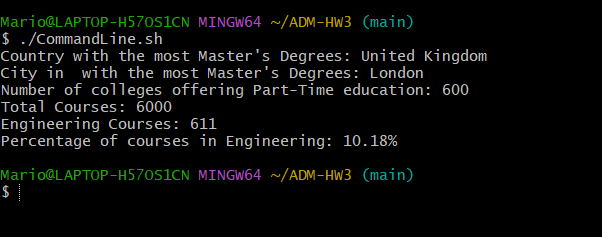

### **ALGORITMIC QUESTION**

**1. Implement a code to solve the above mentioned problem.**

In [ ]:
first_line = list(map(int, input().split()))
d = first_line[0]
sumHours = first_line[1]

In [ ]:
min_times_list = []
max_times_list = []

error_flag = False #to ensure the input is in a logically correct format
for i in range(d):
  input_lines = list(map(int, input().split()))
  if input_lines[0] > input_lines[1]:
    print ("Minimum Time Cannot Exceed Maximum Time")
    error_flag = True
    break
  else:
    min_times_list.append(input_lines[0])
    max_times_list.append(input_lines[1])

if not error_flag: #if the input is in a logically correct format, we save the values to our lists.
  min_times_list = min_times_list
  max_times_list = max_times_list
else: #if the input is not in a logically correct format, we do not save the input into our lists.
  min_times_list = []
  max_times_list = []

In [ ]:
worked_hours_list = []
if (sum(min_times_list)>sumHours) or (len(min_times_list)==0): # the case which leads to an infeasable solution.
  print ("NO")
elif sum(min_times_list)==sumHours: # this part is only to save time if the total hour can only be achieved by using the minimum hours.
  print ("YES")
  print (min_times_list)
else:
  print ("YES")
  while True: #to be able to loop until the following if condition is satisfied.
    for i in range (d-1): #generate the hours for d-1 days randomly.
      worked_hours_list.append(random.randint(min_times_list[i], max_times_list[i]))
    current_sum = sum(worked_hours_list)
    if ((sumHours - current_sum) >= min_times_list[d-1]) and ((sumHours - current_sum) <= max_times_list[d-1]): # logical condition to check if there is an answer with the random hours created so far.
      worked_hours_list.append(sumHours - current_sum) #the last day's hour is equal to the difference between the total hour and the sum of the other days.
      print (worked_hours_list)
      break
    else:
      worked_hours_list = []

**2. What is the time complexity (the Big O notation) of your solution? Please provide a detailed explanation of how you calculated the time complexity.**

In order to calculate the time complexity, I mainly focused on the loops. We have the first "for" loop (for i in range(d)) which has the time complexity of O(n). The statements inside this "for" loop is repetated d times. Time complexity of all our "if" statements are equal to O(1), since they will be executed once. Then, the most important part, we have a "for" loop inside a "while" loop. The "while" loop will be executed until an "if" statement is true. In the best case, it will be executed only once. But in the worst case, the inside of the "while" loop will be executed indefinite amount. This is because there is the randomness element. Considering these, the time complexity cannot be calculated.

**3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). Compare your answer to theirs. Do you believe this is correct? If the two differ, which one is right? (why?)**


The answer of ChatGPT:

> "Input Reading and Validation: The code reads input values, including the number of days (d), total hours (sumHours), and minimum and maximum hours for each day. The loop from for i in range(d) takes O(d) time, as it iterates over the number of days. Within this loop, it checks the validity of input and populates min_times_list and max_times_list.

> Validation and Early Exit: There's a check (if not error_flag) to determine whether the input is valid. If it is, the code proceeds to the next steps. Otherwise, it exits early based on the input validation, which takes O(1) time.

> Handling Infeasible Solutions: There are checks to handle cases where the total minimum hours are greater than the provided total hours or if the minimum times list is empty. These checks are done in O(d) time, as they involve checking the entire list.

> Main Logic (While Loop): There's a while True loop, indicating an indefinite loop until a certain condition is met. This can potentially run multiple times, but the number of iterations is not fixed or determined solely by the input size. Inside this loop, there's a for loop iterating d - 1 times, generating random hours within certain ranges. This loop's time complexity is O(d) as it iterates over the number of days.

> Condition Check and Final Output: Within the while loop, there's a check (if ...) involving arithmetic operations and comparisons. This condition is checked repeatedly until it satisfies certain criteria. The exact number of iterations of this check isn't straightforward to determine without knowing the randomness of the generated values.

> Overall Time Complexity Analysis: The time complexity is mostly influenced by the loops that iterate based on the number of days (d). Input validation and handling infeasible solutions also contribute to the time complexity but in a linear manner. The while loop's time complexity, driven by randomness and the condition inside it, can vary significantly depending on the generated values, making it challenging to precisely determine the overall time complexity in terms of 'n' or 'd'. In conclusion, the time complexity of this code snippet is predominantly influenced by the iterations based on the number of days (d), but the overall complexity is challenging to express definitively due to the unpredictable nature of the loop's termination condition and the randomness involved in the generation of values."

My answer and this answer are almost the same. ChatGPT's answer has more explanations but we both agree the overall time complexity cannot be calculated because of the randomness.

**4. What do you think of the optimality of your code? Do you believe it is optimal? Can you improve? Please elaborate on your response.**

This depends on what Leonardo wants exactly. In our code, the main issue when it comes to optimality and time is about the randomness factor. But, it also makes the results more believable considering the hours will be examined by the HR. Other than this, we tried our code with various different inputs in order to check if it works correctly and concluded that it does. It is also easily maintable since the parameters are given by the user, so it is easy to change and play with the parameter values. If it was asked to improve the time complexity of the code, it is possible to get rid of the randomness. It could be done by:

* An algorithm which assigns the maximum (or minimum) hours for d-1 days and
assigning the sumHours - currentSum for the last day.
* An algorithm which assigns the mean of minimum and maximum hours for d-1 days and assigning the sumHours - currentSum for the last day.